In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 300
v = linspace(0.01,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)



In [2]:
from scipy.stats import norm

def SplitShards(v,day,velocities,dispersions,pops,Psun,\
                GravFocus=False,GalFrame=False,SCO=True):
    weights = norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
    fvS1 = SpeedDist_Triaxial(v,day,dispersions[0,:],v_shift=velocities[0,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)

    fvS2 = 0.5*pops[1]*weights[1]*SpeedDist_Triaxial(v,day,dispersions[1,:],v_shift=velocities[1,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)
    fvS2 += 0.5*pops[2]*weights[2]*SpeedDist_Triaxial(v,day,dispersions[2,:],v_shift=velocities[2,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)
    fvS2 /= trapz(fvS2,v) 

    fvRg = zeros(shape=shape(fvS2))
    fvPro = zeros(shape=shape(fvS2))
    fvN = zeros(shape=shape(fvS2))
    for i in range(0,nshards):
        if names[i].startswith('R'):
            fvRg += weights[i]*pops[i]*SpeedDist_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)

        if names[i]=='C2':
            fvC2 = SpeedDist_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)

        if names[i].startswith('Ca'):
            fvPro += weights[i]*pops[i]*SpeedDist_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)

        if names[i].startswith('N'):
            fvN += weights[i]*pops[i]*SpeedDist_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GravFocus=GravFocus,GalFrame=GalFrame,SmoothCutoff=SCO)
    fvPro /= trapz(fvPro,v) 
    fvN /= trapz(fvN,v)
    fvRg /= trapz(fvRg,v)
    fvAll = vstack((fvS1,fvS2,fvRg,fvPro,fvN))
    labs = array(['S1','S2','Retrograde','Prograde','Low energy'])
    return fvAll,labs

fvAll_gal,labs = SplitShards(v,day,velocities,dispersions,pops,Psun,GravFocus=False,GalFrame=True,SCO=False)
fvAll_lab,_ = SplitShards(v,day,velocities,dispersions,pops,Psun,GravFocus=False,GalFrame=False,SCO=True)
fvAll_gf,_ = SplitShards(v,day,velocities,dispersions,pops,Psun,GravFocus=True,GalFrame=False,SCO=True)

        

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:53: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))



In [3]:
# Smooth cutoff or sharp cutoff?
SCO = True
# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta,SmoothCutoff=SCO) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True,SmoothCutoff=SCO) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True,SmoothCutoff=SCO) # Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,day,sig_iso,GalFrame=True,SmoothCutoff=SCO) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,day,sig_beta,GalFrame=True,SmoothCutoff=SCO) # Galactic frame Sausage

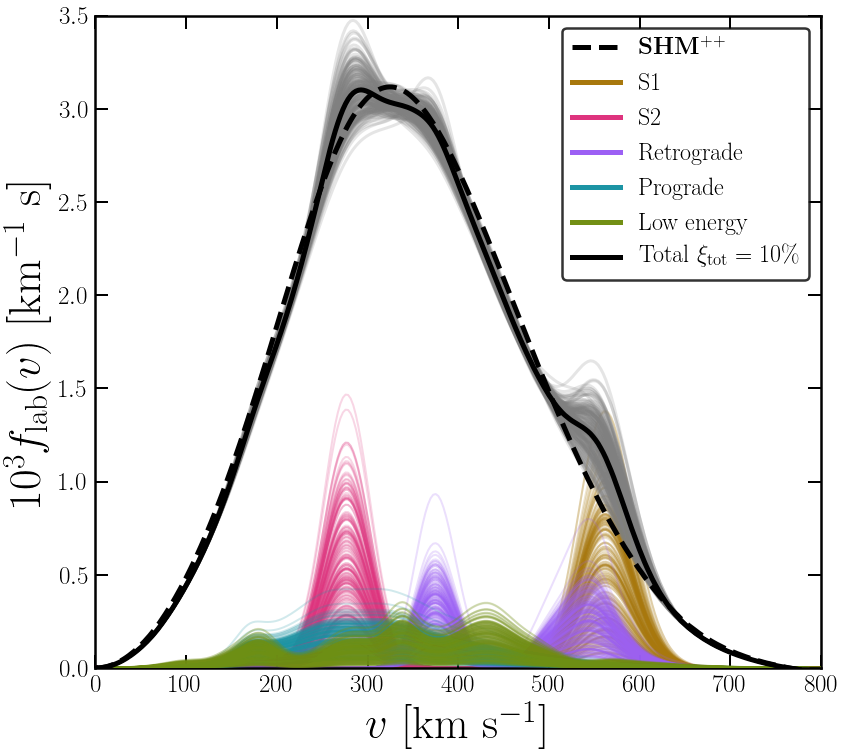

In [4]:
from numpy import random
import matplotlib.cm as cm
import cmocean
# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab1 = r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]"


ng = shape(fvAll_gal)[0]
def randxi(xi_tot,Sort=True):
    xi = random.uniform(0.05,0.7,size=ng)
    #w0 = array([1.0,1.0,2.0,2.0])
    #xi = random.normal(w0,w0*0.2,ng)
    xi = xi_tot*xi/sum(xi)
    if Sort:
        xi = sort(xi)
    xi = repeat(xi[newaxis],n,axis=0).T
    return xi

fig,ax1 = MySquarePlot(xlab,ylab1)

eta_saus = 0.2
xi_tot = 0.1
fv0xi_gf = (1-eta_saus-xi_tot)*fv_Iso_gf + eta_saus*fv_Saus_gf
fv0_gf = (1-eta_saus)*fv_Iso_gf + eta_saus*fv_Saus_gf

cols = cmocean.cm.phase(linspace(0,0.9,ng))

ntrials = 200
KS = zeros(shape=ntrials)

rs = 2
xiall = zeros(shape=(ntrials,ng))
xi_tot = 0.1
alph = 0.2
for i in range(0,ntrials):
    xi = randxi(xi_tot,Sort=False)
    xiall[i,:] = xi[:,0]
    fvi1 = fvAll_gf*xi
    for j in range(0,ng):
        ax1.plot(v,rs*1e3*fvi1[j,:],'-',lw=2,color=cols[j,:],zorder=j,alpha=alph)
    fvS = sum(fvi1,axis=0)
    ax1.plot(v,1e3*(fv0xi_gf+fvS),'-',color='gray',lw=3,zorder=10,alpha=alph)
    F0 = cumtrapz(fv0_gf,v)
    F1 = cumtrapz(fv0xi_gf+fvS,v)
    KS[i] = amax(abs(F0-F1))

ax1.plot(v,1e3*fv0_gf,'k--',lw=5,zorder=10,label=r'{\bf SHM}$^{++}$')

# For legend
for j in range(0,ng):
        ax1.plot(-v,rs*1e3*fvi1[j,:],'-',lw=5,color=cols[j,:],zorder=ng-j,alpha=1.0,label=labs[j])
ax1.plot(-v,1e3*(fv0xi_gf+fvS),'-',color='k',lw=5,zorder=5,alpha=1.0,label=r'Total $\xi_{\rm tot} = 10\%$')


# # max KS
# xi = squeeze(xiall[KS==amax(KS),:])
# fvi_maxKS = sum(repeat(xi[newaxis],n,axis=0).T*fvAll_gf,axis=0)
# ax1.plot(v,1e3*(fv0xi_gf+fvi_maxKS),'-',color='k',lw=3,zorder=10,label='Benchmark')

# equal weighting
xi = xi_tot*array([1.0,1.0,1.0,1.0,1.0])/5.0
fvi_equal = sum(repeat(xi[newaxis],n,axis=0).T*fvAll_gf,axis=0)
ax1.plot(v,1e3*(fv0xi_gf+fvi_equal),'-',color='k',lw=5,zorder=10)



ax1.set_xlim(left=0,right=800.0)
ax1.set_ylim(bottom=0,top=3.5)

leg = ax1.legend(loc='upper right',fontsize=24,edgecolor='k')
leg.get_frame().set_linewidth(2.5)


# Save
plt.show()
pltname = 'fv_Shards'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight') 

In [8]:
v1 = linspace(-750,750,n)

fv3_Iso_lab = VelocityDist1D_Triaxial(v1,day,sig_iso,GalFrame=True) # Round halo
fv3_Saus_lab = VelocityDist1D_Triaxial(v1,day,sig_beta,GalFrame=True) # Sausage

In [9]:
from scipy.stats import norm

def SplitShards3D(v,day,velocities,dispersions,pops,Psun,\
                GravFocus=False,GalFrame=False,SCO=True):
    weights = norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)

    fvS1 = VelocityDist1D_Triaxial(v,day,dispersions[0,:],v_shift=velocities[0,:],GalFrame=True)

    fvS2 = 0.5*pops[1]*weights[1]*VelocityDist1D_Triaxial(v,day,dispersions[1,:],v_shift=velocities[1,:],GalFrame=True)
    fvS2 += 0.5*pops[2]*weights[2]*VelocityDist1D_Triaxial(v,day,dispersions[2,:],v_shift=velocities[2,:],GalFrame=True) 

    fvRg = zeros(shape=shape(fvS2))
    fvPro = zeros(shape=shape(fvS2))
    fvN = zeros(shape=shape(fvS2))
    for i in range(0,nshards):
        if names[i].startswith('R'):
            fvRg += weights[i]*pops[i]*VelocityDist1D_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GalFrame=True)
            
        if names[i].startswith('Ca'):
            fvPro += weights[i]*pops[i]*VelocityDist1D_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GalFrame=True)

        if names[i].startswith('N'):
            fvN += weights[i]*pops[i]*VelocityDist1D_Triaxial(v,day,dispersions[i,:],v_shift=velocities[i,:],GalFrame=True)
    
    for i in range(0,3):
        fvS2[i,:] /= trapz(fvS2[i,:],v)
        fvPro[i,:] /= trapz(fvPro[i,:],v) 
        fvN[i,:] /= trapz(fvN[i,:],v)
        fvRg[i,:] /= trapz(fvRg[i,:],v)
        
    fvAll = dstack((fvS1,fvS2,fvRg,fvPro,fvN))
        
    labs = array(['S1','S2','Rtg','Pro','Low-E'])
    return fvAll,labs

fvAll_lab,labs = SplitShards3D(v1,day,velocities,dispersions,pops,Psun)

   

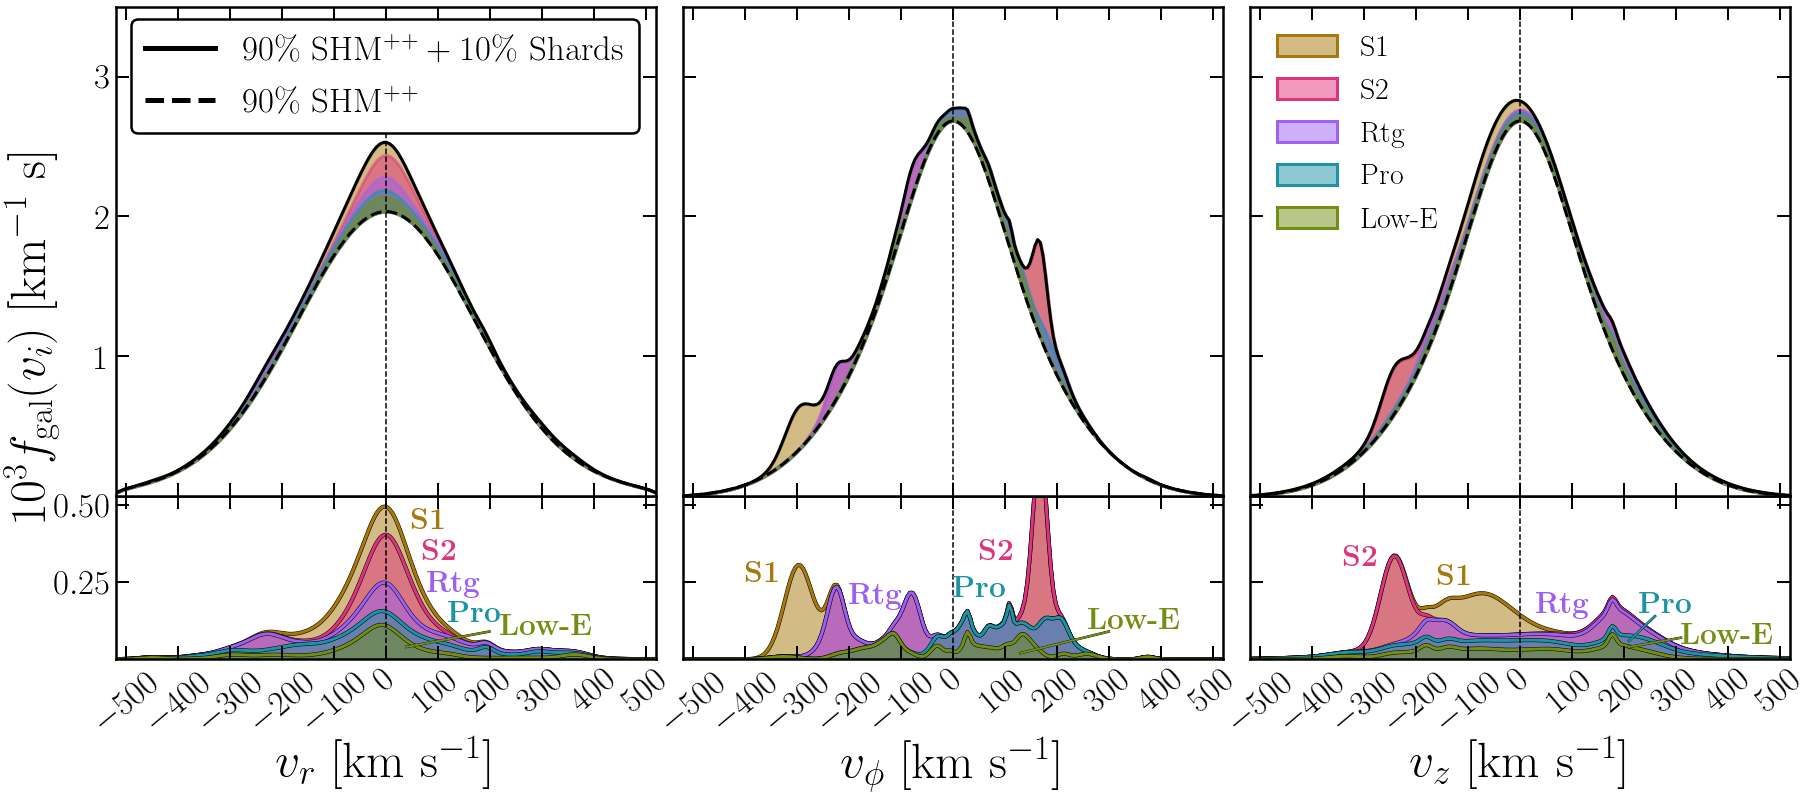

In [20]:
eta_saus = 0.2
xi_tot = 0.1
fv0xi = (1-eta_saus-xi_tot)*fv3_Iso_lab + eta_saus*fv3_Saus_lab
fv0 = (1-eta_saus)*fv3_Iso_lab + eta_saus*fv3_Saus_lab

#vlab = LabFuncs.LabVelocitySimple(day)
vlab = array([0.0,0.0,0.0])

xlab1 = r"$v_r$ [km s$^{-1}$]"
xlab2 = r"$v_\phi$ [km s$^{-1}$]"
xlab3 = r"$v_z$ [km s$^{-1}$]"
ylab1 = r"$10^3 f_{\rm gal}(v_i)$ [km$^{-1}$ s]"
wspace= 0.05
hspace = 0.0
size_y=12
size_x=30
tfs=35
lfs=50
ymin = 1e-3
ymax = 3.5
vmax = 520.0
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
fig, axarr = plt.subplots(4, 3,figsize=(size_x,size_y))
gs = gridspec.GridSpec(4, 3)
gs.update(wspace=wspace,hspace=hspace)
ax1 = plt.subplot(gs[0:-1,0])
ax2 = plt.subplot(gs[0:-1,1])
ax3 = plt.subplot(gs[0:-1,2])
ax11 = plt.subplot(gs[-1,0])
ax22 = plt.subplot(gs[-1,1])
ax33 = plt.subplot(gs[-1,2])
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=5)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax2.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=5)
ax2.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax3.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=5)
ax3.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax11.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=5)
ax11.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax22.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=5)
ax22.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax33.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=5)
ax33.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax11.set_xlabel(xlab1,fontsize=lfs)
ax11.set_ylabel(ylab1,fontsize=lfs) 
ax22.set_xlabel(xlab2,fontsize=lfs)
ax33.set_xlabel(xlab3,fontsize=lfs)



sc = 100


ng = shape(fvAll_lab)[2]
cols = cmocean.cm.phase(linspace(0,0.9,ng))

alph = 1.0

xi = array([0.2,0.2,0.2,0.2,0.2])
xi = xi*xi_tot/sum(xi)

x0 = 1.0*fv0xi[0,:]
y0 = 1.0*fv0xi[1,:]
z0 = 1.0*fv0xi[2,:]

x0 = 0.0
y0 = 0.0
z0 = 0.0
zor = 0
for i in flipud(range(0,ng)):
    x0 += xi[i]*fvAll_lab[0,:,i]
    y0 += xi[i]*fvAll_lab[1,:,i]
    z0 += xi[i]*fvAll_lab[2,:,i]
    
    ax11.fill_between(v1,1e3*x0,y2=0.0,alpha=alph/2,lw=3,color=cols[i,:],zorder=zor)
    ax22.fill_between(v1,1e3*y0,y2=0.0,alpha=alph/2,lw=3,color=cols[i,:],zorder=zor)
    ax33.fill_between(v1,1e3*z0,y2=0.0,alpha=alph/2,lw=3,color=cols[i,:],zorder=zor)

    ax1.fill_between(v1,1e3*(x0+fv0xi[0,:]),y2=1e3*fv0xi[0,:],alpha=alph/2,lw=3,color=cols[i,:],zorder=zor)
    ax2.fill_between(v1,1e3*(y0+fv0xi[1,:]),y2=1e3*fv0xi[1,:],alpha=alph/2,lw=3,color=cols[i,:],zorder=zor)
    ax3.fill_between(v1,1e3*(z0+fv0xi[2,:]),y2=1e3*fv0xi[2,:],alpha=alph/2,lw=3,color=cols[i,:],zorder=zor)

    ax11.plot(v1,1e3*x0,'-',lw=4,color='k',zorder=zor)
    ax22.plot(v1,1e3*y0,'-',lw=4,color='k',zorder=zor)
    ax33.plot(v1,1e3*z0,'-',lw=4,color='k',zorder=zor)
    ax11.plot(v1,1e3*x0,'-',lw=3,color=cols[i,:],zorder=zor)
    ax22.plot(v1,1e3*y0,'-',lw=3,color=cols[i,:],zorder=zor)
    ax33.plot(v1,1e3*z0,'-',lw=3,color=cols[i,:],zorder=zor)
    zor -= 1

ax1.plot(v1,1e3*fv0xi[0,:],'k--',lw=3,zorder=1)
ax2.plot(v1,1e3*fv0xi[1,:],'k--',lw=3,zorder=1)
ax3.plot(v1,1e3*fv0xi[2,:],'k--',lw=3,zorder=1)
   
x0 += fv0xi[0,:]
y0 += fv0xi[1,:]
z0 += fv0xi[2,:]  
ax1.plot(v1,1e3*x0,'k-',lw=3,zorder=1)
ax2.plot(v1,1e3*y0,'k-',lw=3,zorder=1)
ax3.plot(v1,1e3*z0,'k-',lw=3,zorder=1)

ax1.plot([0,0],[0,ymax],'k--')
ax2.plot([0,0],[0,ymax],'k--')
ax3.plot([0,0],[0,ymax],'k--')

# for legend
ax2.plot(v1,-1e3*fv0[0,:]-1000,'k-',lw=5,label=r'$90\%$ SHM$^{++}+10\%$ Shards')
ax2.plot(v1,-1e3*fv0[0,:]-1000,'k--',lw=5,label=r'$90\%$ SHM$^{++}$')
#for i in range(0,ng):
    #ax2.plot(v1,-fv0[0,:]-1000,'-',lw=10,color=cols[i,:],label=labs[i])
leg = ax2.legend(loc='upper right',fontsize=35,edgecolor='k',facecolor='w',framealpha=1.0,bbox_to_anchor=(-0.05, 1.01),ncol=1)
leg.get_frame().set_linewidth(2.5)


for i in range(0,ng):
    ax3.fill_between(v1,-fv0[0,:]-1000,y2=-1000,lw=3,facecolor=col_alpha(cols[i,:],alph/2),label=labs[i],edgecolor=cols[i,:])
leg = ax3.legend(frameon=False,loc='upper left',fontsize=30,edgecolor='k',facecolor='w',framealpha=1.0,ncol=1)
leg.get_frame().set_linewidth(2.5)

#ax1.set_yscale('log')
#ax2.set_yscale('log')
#ax3.set_yscale('log')

tx = arange(-800,800,100)
plt.sca(ax1)
plt.xticks(tx, rotation=40)
plt.sca(ax2)
plt.xticks(tx, rotation=40)
plt.sca(ax3)
plt.xticks(tx, rotation=40)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

ax11.yaxis.set_label_coords(-0.1,2.0)


ax22.set_yticklabels([])
ax33.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax1.set_zorder(1)
ax2.set_zorder(1)
ax3.set_zorder(1)

ax1.set_xlim([-vmax-vlab[0],vmax-vlab[0]])
ax1.set_ylim(bottom=ymin,top=ymax)
ax2.set_xlim([-vmax-vlab[1],vmax-vlab[1]])
ax2.set_ylim(bottom=ymin,top=ymax)
ax3.set_xlim([-vmax-vlab[2],vmax-vlab[2]])
ax3.set_ylim(bottom=ymin,top=ymax)



ymax = 0.53
plt.sca(ax11)
plt.xticks(tx, rotation=40)
plt.sca(ax22)
plt.xticks(tx, rotation=40)
plt.sca(ax33)
plt.xticks(tx, rotation=40)
ax11.set_xlim([-vmax-vlab[0],vmax-vlab[0]])
ax11.set_ylim(bottom=ymin,top=ymax)
ax22.set_xlim([-vmax-vlab[1],vmax-vlab[1]])
ax22.set_ylim(bottom=ymin,top=ymax)
ax33.set_xlim([-vmax-vlab[2],vmax-vlab[2]])
ax33.set_ylim(bottom=ymin,top=ymax)
ax11.plot([0,0],[0,ymax],'k--')
ax22.plot([0,0],[0,ymax],'k--')
ax33.plot([0,0],[0,ymax],'k--')

shx = 19
ax11.text(30+shx,0.42,r'{\bf '+labs[0]+'}',color=cols[0,:],fontsize=30)
ax11.text(50+shx,0.32,r'{\bf '+labs[1]+'}',color=cols[1,:],fontsize=30)
ax11.text(60+shx,0.22,r'{\bf '+labs[2]+'}',color=cols[2,:],fontsize=30)
ax11.text(100+shx,0.12,r'{\bf '+labs[3]+'}',color=cols[3,:],fontsize=30)
ax11.text(200+shx,0.08,r'{\bf '+labs[4]+'}',color=cols[4,:],fontsize=30)

ax11.plot([180+shx,20+shx],[0.09,0.04],'k-',lw=2.5)
ax11.plot([180+shx,20+shx],[0.09,0.04],'-',lw=2,color=cols[4,:])



shx = 250
ax22.text(-650+shx,0.25,r'{\bf '+labs[0]+'}',color=cols[0,:],fontsize=30)
ax22.text(-200+shx,0.32,r'{\bf '+labs[1]+'}',color=cols[1,:],fontsize=30)
ax22.text(-450+shx,0.18,r'{\bf '+labs[2]+'}',color=cols[2,:],fontsize=30)
ax22.text(-250+shx,0.2,r'{\bf '+labs[3]+'}',color=cols[3,:],fontsize=30)
ax22.text(10+shx,0.1,r'{\bf '+labs[4]+'}',color=cols[4,:],fontsize=30)

ax22.plot([50+shx,-120+shx],[0.09,0.02],'k-',lw=2.5)
ax22.plot([50+shx,-120+shx],[0.09,0.02],'-',lw=2,color=cols[4,:])

shx = 10
ax33.text(-170+shx,0.24,r'{\bf '+labs[0]+'}',color=cols[0,:],fontsize=30)
ax33.text(-350+shx,0.3,r'{\bf '+labs[1]+'}',color=cols[1,:],fontsize=30)
ax33.text(20+shx,0.15,r'{\bf '+labs[2]+'}',color=cols[2,:],fontsize=30)
ax33.text(220+shx,0.15,r'{\bf '+labs[3]+'}',color=cols[3,:],fontsize=30)
ax33.text(300+shx,0.05,r'{\bf '+labs[4]+'}',color=cols[4,:],fontsize=30)

ax33.plot([250+shx,200+shx],[0.14,0.06],'k-',lw=2.5)
ax33.plot([250+shx,200+shx],[0.14,0.06],'-',lw=2,color=cols[3,:])

ax33.plot([300+shx,200+shx],[0.07,0.04],'k-',lw=2.5)
ax33.plot([300+shx,200+shx],[0.07,0.04],'-',lw=2,color=cols[4,:])

# Save
plt.show()
pltname = 'fv3_Shards'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight') 